# Preliminary Analysis of ASR Transcripts

This notebook performs a comparative analysis between Control (CN) and Alzheimer's (AD) patients on the **training set**.

**Execution Logic:**
1. Determine the path of ASR transcripts based on `config.yml`.
2. Load a `WhisperX` model for alignment.
3. For each audio file in the training set, load the **best hypothesis** text transcript from the corresponding JSON.
4. Perform forced alignment between audio and text to obtain word-level timestamps.
5. Calculate a complete set of metrics (including timestamp-based ones) and visualize them.

In [1]:
import os
import glob
import json
import yaml
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import sys
from tqdm import tqdm

sys.path.append('..')
from src.utils import _get_project_paths

## 1. Model Loading and Path Definition

In [2]:
import torch
import whisperx

BATCH_SIZE = 16 
COMPUTE_TYPE = "float16" if torch.cuda.is_available() else "int8"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# We use a base model, it is sufficient for alignment
ASR_MODEL_NAME = "large-v3"

print(f"Loading ASR model '{ASR_MODEL_NAME}' on {DEVICE}...")
asr_model = whisperx.load_model(ASR_MODEL_NAME, DEVICE, compute_type=COMPUTE_TYPE, language="en")

print("Loading alignment model...")
align_model, align_metadata = whisperx.load_align_model(language_code="en", device=DEVICE)

print("Models loaded.")

Loading ASR model 'large-v3' on cuda...


/home/speechlab/anaconda3/envs/whisperx-dev/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/speechlab/anaconda3/envs/whisperx-dev/lib/python3.10/site-packages/pyannote/audio/core/io.py:212: UserWarning: torchaudio._backend.list_audio_backends has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  torchaudio.list_audio_backends()
/home/speechlab/anaconda3/envs/whisperx-dev/lib/python3.10/site-packages/speechbrain/utils/torch_audio_backend.py:57: UserWarning: torchaudio._backend.list_audio_backen

2025-11-26 12:24:02 - whisperx.vads.pyannote - INFO - Performing voice activity detection using Pyannote...


Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.5.5. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../Development/whisperX/whisperx/assets/pytorch_model.bin`


Model was trained with pyannote.audio 0.0.1, yours is 3.4.0. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.8.0+cu128. Bad things might happen unless you revert torch to 1.x.
Loading alignment model...


/home/speechlab/anaconda3/envs/whisperx-dev/lib/python3.10/site-packages/pyannote/audio/core/io.py:212: UserWarning: torchaudio._backend.list_audio_backends has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  torchaudio.list_audio_backends()


Models loaded.


## 2. Alignment and Data Preparation

Iterate over the training set audio files, load the existing text transcript (from the ASR specified in `config.yml`), and perform alignment to obtain timestamps.

In [3]:
with open("../config.yml", 'r') as f:
    config = yaml.safe_load(f)

if config['model_type'] == 'confidence':
    config['model_name'] = config['model_name_large']
else:
    config['model_name'] = config['model_name_base']

paths = _get_project_paths(config)
for path in paths.items():
    paths[path[0]] = os.path.join("..", path[1])

TRANSCRIPTS_PATH = paths['transcripts_root']
AUDIO_ROOT = os.path.join("..", config['data']['train_audio_root'])

print(f"ASR Transcripts Path: {TRANSCRIPTS_PATH}")
print(f"Audio Path: {AUDIO_ROOT}")

audio_files = glob.glob(os.path.join(AUDIO_ROOT, "*/*.wav"))
print(f"Found {len(audio_files)} audio files in the training set.")

all_data = []
for audio_path in tqdm(audio_files):
    label_str = os.path.basename(os.path.dirname(audio_path))
    label = 1 if label_str == 'ad' else 0
    file_id = os.path.splitext(os.path.basename(audio_path))[0]
    
    # Load pre-generated transcript to get reference text
    json_path = os.path.join(TRANSCRIPTS_PATH, 'train', label_str, f"{file_id}.json")
    with open(json_path, 'r') as f:
        transcript_data = json.load(f)
    # Use text from the first (best) hypothesis
    full_text = transcript_data[0]['text'].strip()
    avg_log_score = transcript_data[0]['avg_log_score']
        
    audio = whisperx.load_audio(audio_path)
    
    # First transcribe with base model to get segments
    asr_result = asr_model.transcribe(audio, batch_size=BATCH_SIZE)
    # Then align segments
    aligned_result = whisperx.align(asr_result["segments"], 
                                    align_model, 
                                    align_metadata, 
                                    audio, 
                                    DEVICE, 
                                    return_char_alignments=False)
    words_data = aligned_result.get('word_segments', [])
    
    # Calculate total duration (end of last word)
    total_duration = 0
    if words_data:
        total_duration = words_data[-1].get('end', 0)
        
    all_data.append({
        'file_id': file_id,
        'label': label,
        'label_str': label_str.upper(),
        'full_text': full_text, # Text from config ASR
        'words_data': words_data, # Timestamps from alignment
        'duration': total_duration,
        'avg_log_score': avg_log_score # Score from config ASR
    })

df = pd.DataFrame(all_data)
print(f"\nCreated DataFrame with {len(df)} rows.")
df.head()

ASR Transcripts Path: ../results/transcripts/whisperx/large-v3
Audio Path: ../data/ADReSSo21-diagnosis-train/ADReSSo21/diagnosis/train/audio
Found 166 audio files in the training set.


  0%|          | 0/166 [00:00<?, ?it/s]/home/speechlab/anaconda3/envs/whisperx-dev/lib/python3.10/site-packages/pyannote/audio/utils/reproducibility.py:74: ReproducibilityWarning: TensorFloat-32 (TF32) has been disabled as it might lead to reproducibility issues and lower accuracy.
It can be re-enabled by calling
   >>> import torch
   >>> torch.backends.cuda.matmul.allow_tf32 = True
   >>> torch.backends.cudnn.allow_tf32 = True
See https://github.com/pyannote/pyannote-audio/issues/1370 for more details.

  warnings.warn(
100%|██████████| 166/166 [03:30<00:00,  1.27s/it]


Created DataFrame with 166 rows.


,file_id,label,label_str,full_text,words_data,duration,avg_log_score
0,adrso234,1,AD,What action do you see going on in that pictur...,"[{'word': 'What', 'start': 0.031, 'end': 0.231...",71.719,-0.272265
1,adrso253,1,AD,"Well, my boy's trying to get some cookies. And...","[{'word': 'Well,', 'start': 1.651, 'end': 1.97...",67.095,-0.177032
2,adrso059,1,AD,"in the picture. Well, it's kind of calamity, i...","[{'word': 'in', 'start': 0.031, 'end': 0.331, ...",45.985,-0.166882
3,adrso045,1,AD,this picture and tell me everything that you s...,"[{'word': 'this', 'start': 0.419, 'end': 0.739...",219.493,-0.093876
4,adrso054,1,AD,What's happening in that picture? What's happe...,"[{'word': 'What's', 'start': 0.318, 'end': 0.5...",155.537,-0.251365


## 3. Metrics Calculation

Now that we have timestamps, we can calculate all metrics.

In [4]:
def calculate_metrics(row):
    words_data = row['words_data']
    text = row['full_text']
    duration = row['duration']
    
    # Word Count (from aligned words)
    clean_words = [w['word'] for w in words_data if 'word' in w]
    word_count = len(clean_words)
    
    # Words Per Minute (WPM)
    wpm = (word_count / duration) * 60 if duration > 0 else 0
    
    # Pause Analysis
    pauses = []
    for i in range(len(words_data) - 1):
        current_word = words_data[i]
        next_word = words_data[i+1]
        if 'end' in current_word and 'start' in next_word:
            pause = next_word['start'] - current_word['end']
            if pause > 0.15: # Threshold to consider a pause (150ms)
                pauses.append(pause)
    avg_pause_duration = np.mean(pauses) if pauses else 0
    pause_rate = (len(pauses) / duration) if duration > 0 else 0 # Pauses per second
    
    # Lexical Diversity (TTR)
    original_words = [w for w in text.split() if not re.match(r'\[(UH|UM)\]', w)]
    ttr = len(set(original_words)) / len(original_words) if original_words else 0
    
    return pd.Series([
        word_count, wpm, avg_pause_duration, pause_rate, ttr
    ])

metric_cols = [
    'word_count', 'wpm', 'avg_pause_duration', 'pause_rate', 'ttr'
]

df_metrics = df.apply(calculate_metrics, axis=1)
df_metrics.columns = metric_cols
df = pd.concat([df, df_metrics], axis=1)

df.head()

,file_id,label,label_str,full_text,words_data,duration,avg_log_score,word_count,wpm,avg_pause_duration,pause_rate,ttr
0,adrso234,1,AD,What action do you see going on in that pictur...,"[{'word': 'What', 'start': 0.031, 'end': 0.231...",71.719,-0.272265,96.0,80.313446,1.560667,0.250980,0.614583
1,adrso253,1,AD,"Well, my boy's trying to get some cookies. And...","[{'word': 'Well,', 'start': 1.651, 'end': 1.97...",67.095,-0.177032,101.0,90.319696,1.231333,0.357702,0.683168
2,adrso059,1,AD,"in the picture. Well, it's kind of calamity, i...","[{'word': 'in', 'start': 0.031, 'end': 0.331, ...",45.985,-0.166882,68.0,88.724584,1.529294,0.369686,0.791045
3,adrso045,1,AD,this picture and tell me everything that you s...,"[{'word': 'this', 'start': 0.419, 'end': 0.739...",219.493,-0.093876,432.0,118.090326,0.953790,0.455595,0.406467
4,adrso054,1,AD,What's happening in that picture? What's happe...,"[{'word': 'What's', 'start': 0.318, 'end': 0.5...",155.537,-0.251365,104.0,40.119071,3.542926,0.173592,0.725490


### Hesitation Analysis from CrisperWhisper Transcripts

We calculate the count of `[UH]` and `[UM]` using transcripts generated by the `nyrahealth_faster_CrisperWhisper` model for higher accuracy in hesitation detection.

In [5]:
CRISPER_TRANSCRIPTS_PATH = '../results/transcripts/whisperx/nyrahealth_faster_CrisperWhisper'

def get_hesitations_from_crisper(row):
    label_str = row['label_str'].lower()
    file_id = row['file_id']
    
    json_path = os.path.join(CRISPER_TRANSCRIPTS_PATH, 'train', label_str, f"{file_id}.json")
    
    try:
        with open(json_path, 'r') as f:
            transcript_data = json.load(f)
        
        # Use text from the first (best) hypothesis
        text = transcript_data[0]['text'].strip()
        uh_count = text.count('[UH]')
        um_count = text.count('[UM]')
        return pd.Series([uh_count, um_count])
    except FileNotFoundError:
        print(f"File not found: {json_path}")
        return pd.Series([0, 0])

df[['uh_count', 'um_count']] = df.apply(get_hesitations_from_crisper, axis=1)

print("Hesitation Counts Statistics:")
print(df.groupby('label_str')[['uh_count', 'um_count']].mean())

Hesitation Counts Statistics:
           uh_count  um_count
label_str                    
AD         3.298851  0.436782
CN         2.253165  1.329114


## 4. Visualization and Comparative Analysis

/tmp/ipykernel_1377275/3179538660.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data_cn, data_ad], labels=['CN', 'AD'])


Saved plot to ../results/figures/word_count.svg


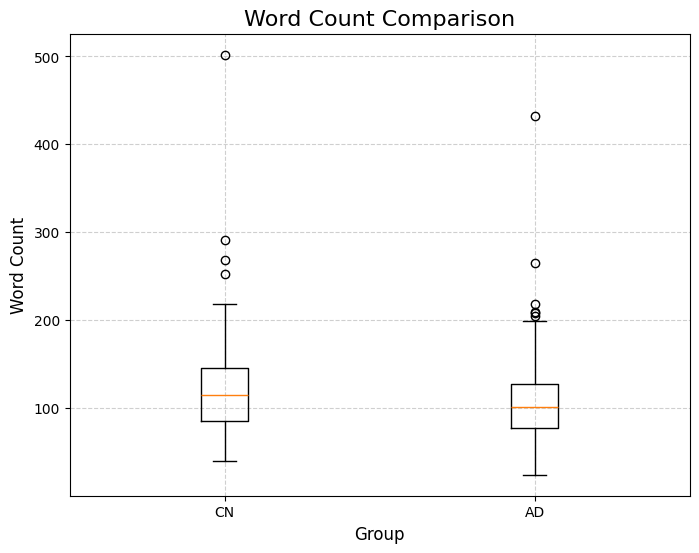

In [6]:
# Define directory for saving plots
FIGURES_DIR = "../results/figures"
os.makedirs(FIGURES_DIR, exist_ok=True)

def plot_metric(metric_name, title, xlabel, filename=None):
    plt.figure(figsize=(8, 6))
    
    # Prepare data for matplotlib
    data_cn = df[df['label_str'] == 'CN'][metric_name].dropna()
    data_ad = df[df['label_str'] == 'AD'][metric_name].dropna()
    
    plt.boxplot([data_cn, data_ad], labels=['CN', 'AD'])
    
    plt.title(title, fontsize=16)
    plt.xlabel('Group', fontsize=12)
    plt.ylabel(xlabel, fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    
    if filename:
        save_path = os.path.join(FIGURES_DIR, filename)
        plt.savefig(save_path)
        print(f"Saved plot to {save_path}")
        
    plt.show()

plot_metric('word_count', 'Word Count Comparison', 'Word Count', 'word_count.svg')

Saved plot to ../results/figures/wpm.svg


/tmp/ipykernel_1377275/3179538660.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data_cn, data_ad], labels=['CN', 'AD'])


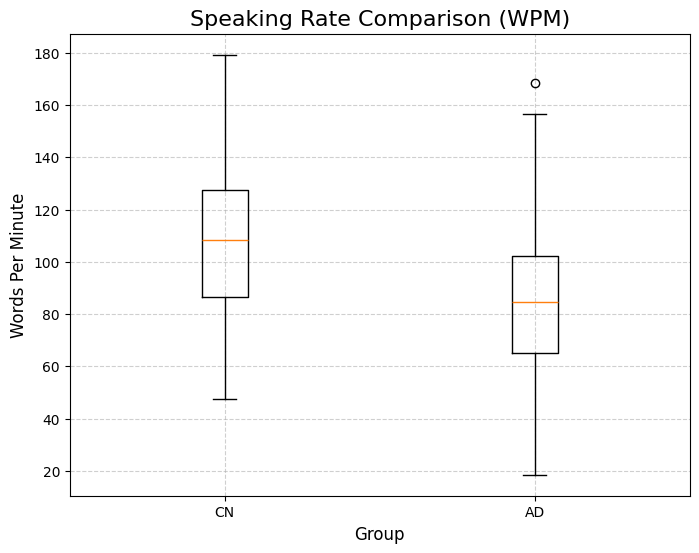

In [7]:
plot_metric('wpm', 'Speaking Rate Comparison (WPM)', 'Words Per Minute', 'wpm.svg')

/tmp/ipykernel_1377275/3179538660.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data_cn, data_ad], labels=['CN', 'AD'])


Saved plot to ../results/figures/avg_pause_duration.svg


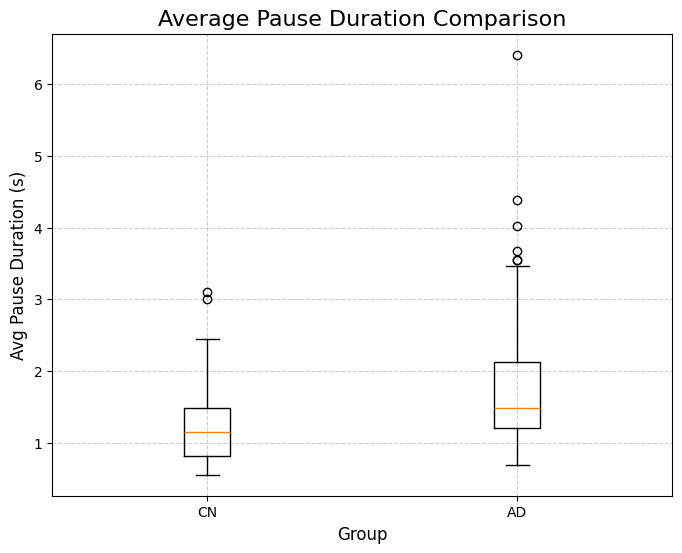

In [8]:
plot_metric('avg_pause_duration', 'Average Pause Duration Comparison', 'Avg Pause Duration (s)', 'avg_pause_duration.svg')

/tmp/ipykernel_1377275/3179538660.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data_cn, data_ad], labels=['CN', 'AD'])


Saved plot to ../results/figures/pause_rate.svg


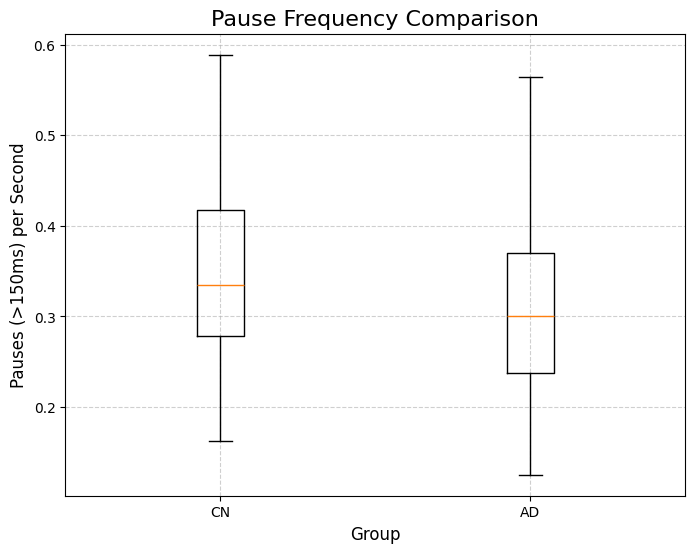

In [9]:
plot_metric('pause_rate', 'Pause Frequency Comparison', 'Pauses (>150ms) per Second', 'pause_rate.svg')

/tmp/ipykernel_1377275/3179538660.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data_cn, data_ad], labels=['CN', 'AD'])


Saved plot to ../results/figures/ttr.svg


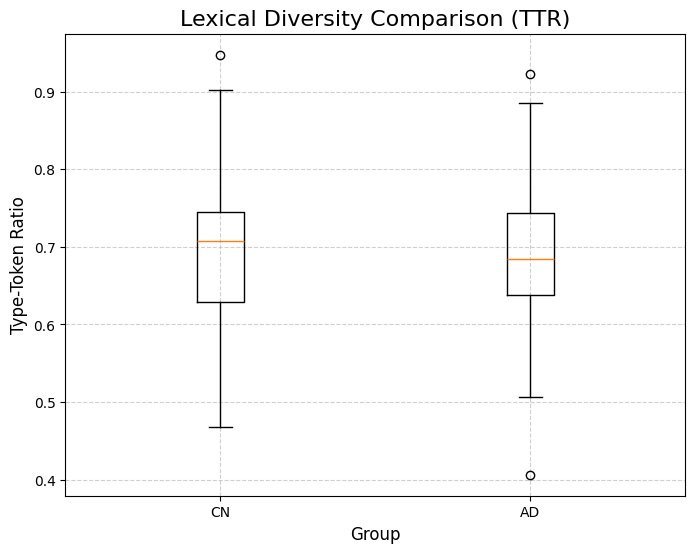

In [10]:
plot_metric('ttr', 'Lexical Diversity Comparison (TTR)', 'Type-Token Ratio', 'ttr.svg')

/tmp/ipykernel_1377275/3179538660.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data_cn, data_ad], labels=['CN', 'AD'])


Saved plot to ../results/figures/uh_count.svg


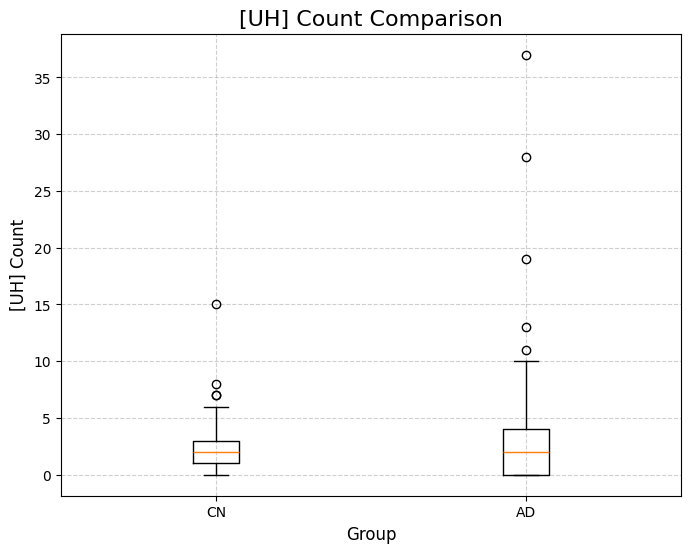

/tmp/ipykernel_1377275/3179538660.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data_cn, data_ad], labels=['CN', 'AD'])


Saved plot to ../results/figures/um_count.svg


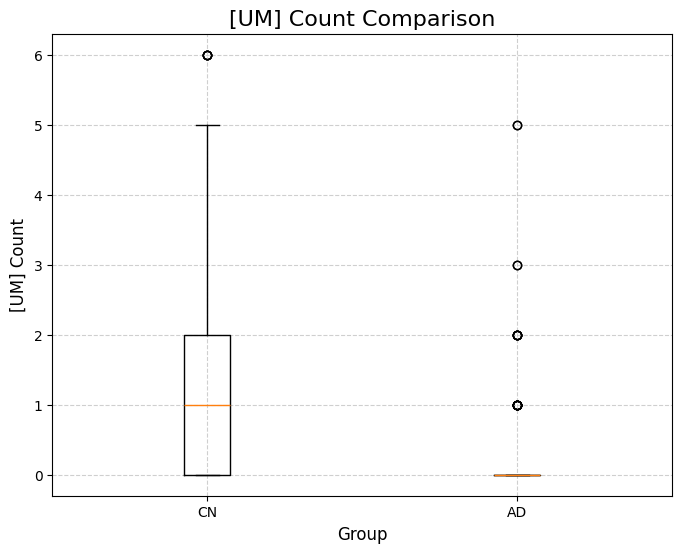

In [11]:
plot_metric('uh_count', '[UH] Count Comparison', '[UH] Count', 'uh_count.svg')
plot_metric('um_count', '[UM] Count Comparison', '[UM] Count', 'um_count.svg')

/tmp/ipykernel_1377275/3179538660.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data_cn, data_ad], labels=['CN', 'AD'])


Saved plot to ../results/figures/confidence.svg


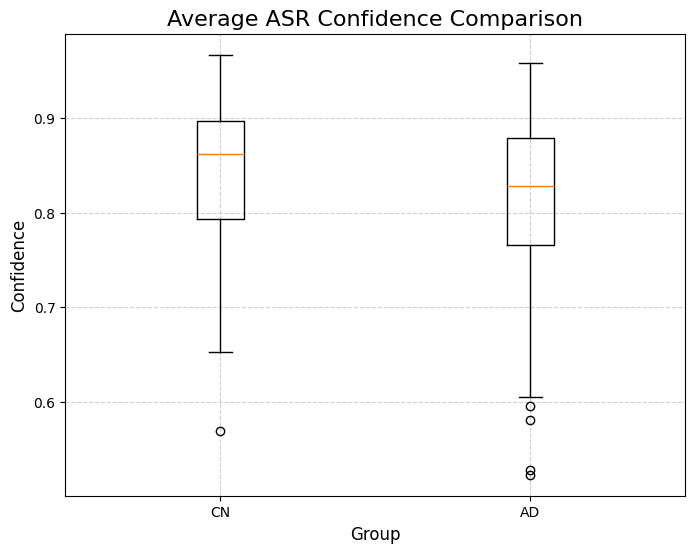

In [12]:
df['confidence_exp'] = np.exp(df['avg_log_score'])
plot_metric('confidence_exp', 'Average ASR Confidence Comparison', 'Confidence', 'confidence.svg')

### MATTR Analysis (Moving-Average Type-Token Ratio)

Simple TTR is sensitive to text length. MATTR is a more robust metric.

/tmp/ipykernel_1377275/3179538660.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data_cn, data_ad], labels=['CN', 'AD'])


Saved plot to ../results/figures/mattr.svg


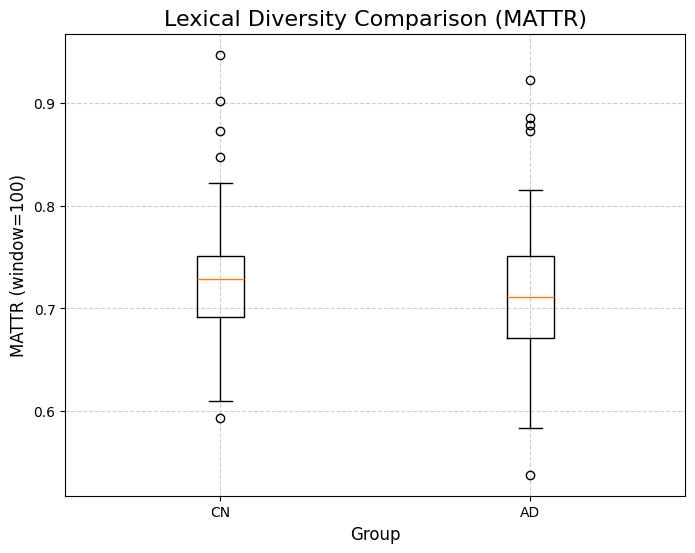

In [13]:
def mattr(words, window_size=100):
    """Calculates the Moving-Average Type-Token Ratio."""
    if len(words) < window_size:
        return len(set(words)) / len(words) if len(words) > 0 else 0
    
    ttrs = []
    for i in range(len(words) - window_size + 1):
        window = words[i:i + window_size]
        ttr = len(set(window)) / window_size
        ttrs.append(ttr)
        
    return np.mean(ttrs) if ttrs else 0

df['mattr'] = df['full_text'].apply(lambda text: mattr([w for w in text.split() if not re.match(r'\[(UH|UM)\]', w)]))

plot_metric('mattr', 'Lexical Diversity Comparison (MATTR)', 'MATTR (window=100)', 'mattr.svg')

In [14]:
# Calculate descriptive statistics for each metric, grouped by label
metrics_to_describe = [
    'word_count', 'wpm', 'avg_pause_duration', 'pause_rate', 'ttr', 'mattr',
    'uh_count', 'um_count', 'confidence_exp'
]

summary_stats = df.groupby('label_str')[metrics_to_describe].agg(['mean', 'std', 'median'])
summary_stats = summary_stats.stack(level=0).unstack(level=0)
summary_stats = summary_stats.rename_axis(index='Metric')

print("Summary Statistics Table by Group")
summary_stats

Summary Statistics Table by Group


/tmp/ipykernel_1377275/413374656.py:8: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  summary_stats = summary_stats.stack(level=0).unstack(level=0)


mean                    std                 median  \
label_str                   AD          CN         AD         CN          AD   
Metric                                                                         
avg_pause_duration    1.758094    1.268880   0.948634   0.564905    1.477250   
confidence_exp        0.808948    0.841537   0.092350   0.081220    0.828791   
mattr                 0.712799    0.724179   0.068404   0.065107    0.711538   
pause_rate            0.306299    0.338682   0.094320   0.092546    0.300652   
ttr                   0.689025    0.694431   0.083399   0.085449    0.684211   
uh_count              3.298851    2.253165   5.613760   2.355944    2.000000   
um_count              0.436782    1.329114   0.996519   1.766654    0.000000   
word_count          111.827586  123.113924  56.892434  66.051260  101.000000   
wpm                  84.747606  109.102387  31.663835  30.234672   84.460780   

                                
label_str                   CN  
Metric                          
avg_pause_duration    1.143943  
confidence_exp        0.862087  
mattr                 0.728750  
pause_rate            0.334322  
ttr                   0.707547  
uh_count              2.000000  
um_count              1.000000  
word_count          115.000000  
wpm                 108.340781